In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
import os
import pickle as pkl
from LRBv2 import LRBv2
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

fontsize = 12

set_matplotlib_defaults()



# IO

In [2]:
# gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"

list_sides = ["iu", "ou"]
data = dict()
sepadd = 2
res = 500

for side in list_sides:
    data[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane")

In [3]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.01,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Cooling curve plots

Text(0.5, 1.0, 'Impurity cooling curves')

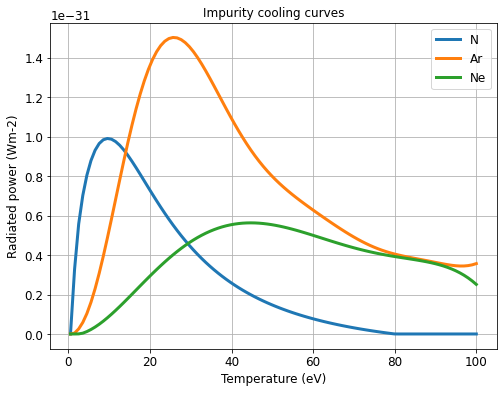

In [29]:
Te = np.linspace(0.5, 100, 100)
Lz = defaultdict(list)

Lfuncs = {"N":LfuncN, "Ar":LfuncAr, "Ne":LfuncNe}

# Lfuncs = {"N full":LfuncNFull, "Ar full":LfuncArFull, "Ne full":LfuncNeFull}

for imp in Lfuncs.keys():
    for x in Te:
        Lz[imp].append(Lfuncs[imp](x))
        
    
fig, ax = plt.subplots(figsize=(8,6))

for imp in Lfuncs.keys():
    ax.plot(Te, Lz[imp], label = imp, linewidth = 3)

ax.grid()
ax.set_xlabel("Temperature (eV)")
ax.set_ylabel("Radiated power (Wm-2)")
ax.legend()
ax.set_title("Impurity cooling curves")

# Impact on performance

In [5]:
imp_study = dict()

imp_labels = ["N", "Ar", "Ne"]

for side in data.keys():
    print("Solving side", side)
    out = []
    results = dict()
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []

    for i, func in enumerate([LfuncN, LfuncAr, LfuncNe]):
        print("Running impurity: {} -- ".format(imp_labels[i]), end="")
        d = data[side].copy()

        constants = constants_default.copy()
        radios = radios_default.copy()
        indexRange = np.linspace(0, d["Xpoint"]-1, 30).astype(int)
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        constants["Lfunc"] = func

        out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                            control_variable = "impurity_frac"))
        out[i]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
        results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
        results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
        results["threshold"].append(out[i]["cvar"][0])
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios

    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    imp_study[side] = results.copy()

Solving side iu
Running impurity: N -- Solving...0...1...3...5...7...9...11...13...14...16...18...20...22...24...26...27...29...31...33...35...37...39...40...42...44...46...48...50...52...54...Complete in 33.8 seconds
Running impurity: Ar -- Solving...0...1...3...5...7...9...11...13...14...16...18...20...22...24...26...27...29...31...33...35...37...39...40...42...44...46...48...50...52...54...Complete in 35.1 seconds
Running impurity: Ne -- Solving...0...1...3...5...7...9...11...13...14...16...18...20...22...24...26...27...29...31...33...35...37...39...40...42...44...46...48...50...52...54...Complete in 34.1 seconds
Solving side ou
Running impurity: N -- Solving...0...6...12...18...25...31...37...43...50...56...62...69...75...81...87...94...100...106...112...119...125...131...138...144...150...156...163...169...175...182...Complete in 32.0 seconds
Running impurity: Ar -- Solving...0...6...12...18...25...31...37...43...50...56...62...69...75...81...87...94...100...106...112...119...125.

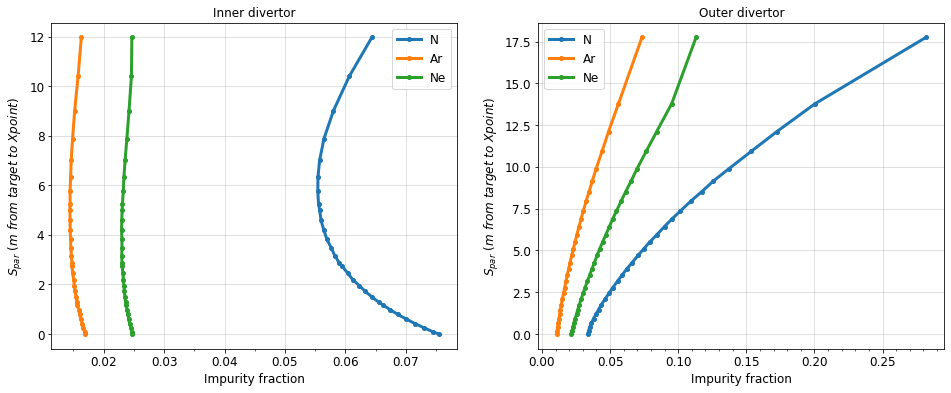

In [6]:
fig, axes = plt.subplots(1,2, figsize = (16,6))

ax = axes[0]

results = imp_study["iu"]
for i, imp in enumerate(imp_labels):
    ax.plot(results["out"][i]["cvar"], results["out"][i]["Splot"], label = "{}".format(imp), linewidth = 3, marker = "o", markersize = 4)
ax.set_xlabel("Impurity fraction")
ax.set_ylabel("$S_{par}\ (m\ from\ target\ to\ Xpoint)$")
ax.grid(alpha = 0.5)
ax.legend()
ax.set_title("Inner divertor")
ax.xaxis.set_minor_locator(MultipleLocator(0.005))
ax.xaxis.set_major_locator(MultipleLocator(0.01))

ax = axes[1]

results = imp_study["ou"]
for i, imp in enumerate(imp_labels):
    ax.plot(results["out"][i]["cvar"], results["out"][i]["Splot"], label = "{}".format(imp), linewidth = 3, marker = "o", markersize = 4)
ax.set_xlabel("Impurity fraction")
ax.set_ylabel("$S_{par}\ (m\ from\ target\ to\ Xpoint)$")
ax.grid(alpha = 0.5)
ax.legend()
ax.set_title("Outer divertor")
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.xaxis.set_major_locator(MultipleLocator(0.05))
# ax.set_xlim(0.001,0.017)

# norm = mpl.colors.BoundaryNorm(results["list_BxBt"], cmap.N, extend= "both")
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),  orientation="vertical", label = "Flux expansion ($B_{x}\//B_{t}$)")
# cb.ax.set_yticklabels(["{:.2f}".format(i) for i in cb.get_ticks()]) 
# "yep"

Text(0.5, 1.0, 'Temperature profiles for scan of front locations')

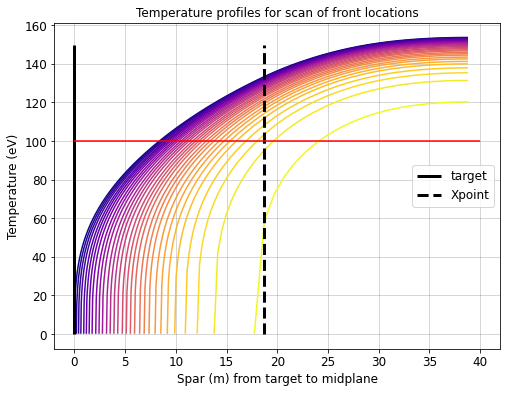

In [7]:
side = "ou"

fig, ax = plt.subplots(figsize=(8,6))
o = imp_study[side]["out"][0]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(o["Tprofiles"]), cmap)   

for i, Tprofile in enumerate(o["Tprofiles"]):
    ax.plot(o["Sprofiles"][i], Tprofile, color = colors[i])
    
ax.vlines(0, 0, 150, zorder = 5, label = "target", color = "black", linewidth = 3)
ax.vlines(data[side]["S"][data[side]["Xpoint"]], 0, 150, zorder = 5, label = "Xpoint", color = "black", linewidth = 3, linestyle = "dashed")
ax.hlines(100,0,40,color ="red", zorder = 5)

ax.legend(loc="center right")
ax.grid(color = "black", alpha = 0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")
ax.set_title("Temperature profiles for scan of front locations")

# Extract Kallenbach curves

In [4]:
kalle = pd.read_excel(r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\L_z(Te) Kallenbach 20Feb18.xlsx", header = 0)
kallearr = np.array(kalle)

In [5]:
imps = ["N", "Ne", "Ar"]

# [ROW, COL]
# Rows offset by -2. 8 here is 10 there
Lz = dict() # Lz[impurity][tau] where tau is residence time
Lz["N"] = dict()
Lz["Ne"] = dict()
Lz["Ar"] = dict()

Tarr = kallearr[8:33,2:10] 

Lz["N"][0.1] = kallearr[34:59,2:10]
Lz["Ne"][0.1] = kallearr[34:59,17:25]
Lz["Ar"][0.1] = kallearr[34:59,32:40]

Lz["N"][1] = kallearr[60:85,2:10]
Lz["Ne"][1] = kallearr[60:85,17:25]
Lz["Ar"][1] = kallearr[60:85,32:40]

Lz["N"][10] = kallearr[86:111,2:10]
Lz["Ne"][10] = kallearr[86:111,17:25]
Lz["Ar"][10] = kallearr[86:111,32:40]

Lz["N"][100] = kallearr[112:137,2:10]
Lz["Ne"][100] = kallearr[112:137,17:25]
Lz["Ar"][100] = kallearr[112:137,32:40]

# A = Lz["N"][100]
# for row in range(A.shape[0]):
#     print(A[row,:])
    
for imp in Lz.keys():
    for tau in Lz[imp].keys():
        Lz[imp][tau] = np.concatenate(Lz[imp][tau]).astype(float)
        
Tarr = (np.concatenate(Tarr)).astype(float)


## Compare against Ryoko's fits

NameError: name 'Lfuncs' is not defined

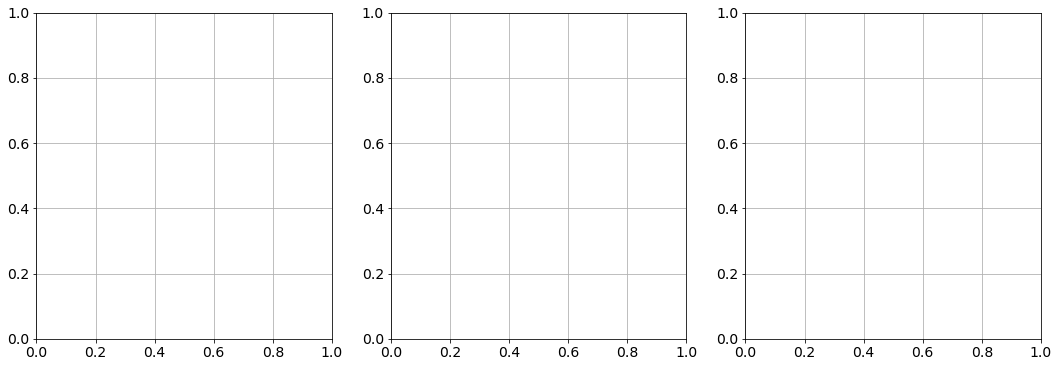

In [6]:


# Lfuncs = {"N":LfuncN, "Ar":LfuncAr, "Ne":LfuncNe}

# # Lfuncs = {"N full":LfuncNFull, "Ar full":LfuncArFull, "Ne full":LfuncNeFull}

# for imp in Lfuncs.keys():
#     for x in Te:
#         Lz[imp].append(Lfuncs[imp](x))
        
store_colors = dict(zip(imps,[plt.get_cmap("tab10")(x) for x in range(3)]))

fig, axes = plt.subplots(1,3,figsize=(18,6))

tau = 1

for i, imp in enumerate(imps):
    ax = axes[i]
    ax.plot(Tarr, [Lfuncs[imp](x) for x in Tarr], color =store_colors[imp], linewidth = 2, linestyle = "solid", label = f"In LRB code")
    # ax.plot(Tarr, Lz[imp][0.1], color = store_colors[imp], linewidth = 2, linestyle = "dotted", label = r"$K., \tau=0.1ms$")
    ax.plot(Tarr, Lz[imp][1], color = store_colors[imp], linewidth = 2, linestyle = "dashed", label = r"$Kallenbach, \tau=1ms$")
    # ax.plot(Tarr, Lz[imp][10], color = store_colors[imp], linewidth = 2, linestyle = (0, (5, 3)), label = r"$K., \tau=10ms$")
    # ax.plot(Tarr, Lz[imp][100], color = store_colors[imp], linewidth = 2, linestyle = (0, (10, 3)), label = r"$K., \tau=100ms$")

    ax.set_xlim(0,300)
    ax.grid()
    ax.set_xlabel("Temperature (eV)")
    ax.set_ylabel("Radiated power (Wm-2)")
    ax.legend(fontsize = 10)
    ax.set_title(f"{imp}", fontsize = 17)

## Test new function

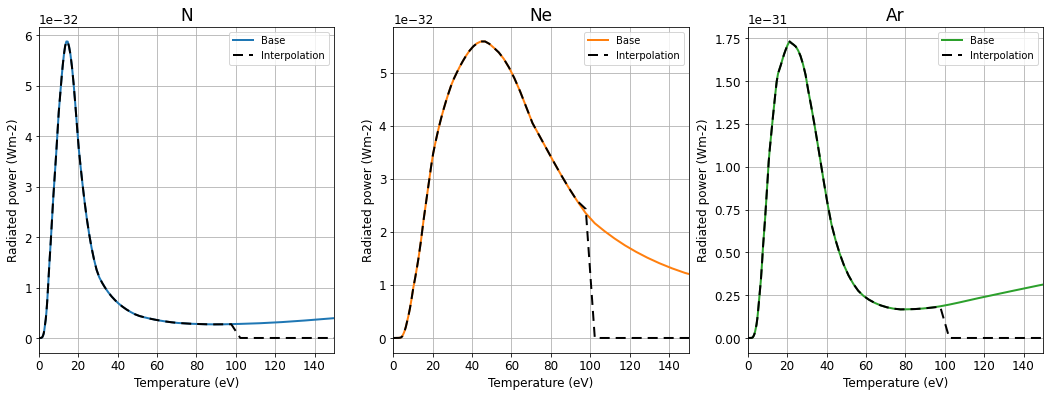

In [20]:
store_colors = dict(zip(imps,[plt.get_cmap("tab10")(x) for x in range(3)]))

fig, axes = plt.subplots(1,3,figsize=(18,6))

T_new = np.insert(Tarr, 0, [0,0.99])

tau = 1

for i, imp in enumerate(imps):
    ax = axes[i]
    ax.plot(Tarr, Lz[imp][1], color = store_colors[imp], linewidth = 2, linestyle = "solid", label = r"Base")
    ax.plot(T_new, LfuncKallenbach(imp)(T_new), color = "black", linewidth = 2, linestyle = (0, (5, 3)), label = r"Interpolation")


    ax.set_xlim(0,150)
    # ax.set_ylim(0,1e-35)
    ax.grid()
    ax.set_xlabel("Temperature (eV)")
    ax.set_ylabel("Radiated power (Wm-2)")
    ax.legend(fontsize = 10)
    ax.set_title(f"{imp}", fontsize = 17)

# Compare performance of Kallenbach vs. original fits

In [36]:
imp_study_K = dict()

imp_labels = ["N", "Ar", "Ne"]

for side in data.keys():
    side = "ou"
    print("Solving side", side)
    out = []
    results = dict()
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []

    for i, imp in enumerate(["N", "Ne", "Ar"]):
        print("Running impurity: {} -- ".format(imp_labels[i]), end="")
        d = data[side].copy()

        constants = constants_default.copy()
        radios = radios_default.copy()
        indexRange = np.linspace(0, d["Xpoint"]-1, 30).astype(int)
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        constants["Lfunc"] = LfuncKallenbach("Ar")
        constants["ne0"] = 1e18

        out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 0.2, acceleration = 0, verbosity = 0,
                                            control_variable = "impurity_frac"))
        
        out[i]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
        results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
        results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
        results["threshold"].append(out[i]["cvar"][0])
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios

    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    imp_study_K[side] = results.copy()

Solving side ou
Running impurity: N -- Solving...******OUTER TIMEOUT! Loosen Ttol or reduce under-relaxation factor. Set verbosity = 2!*******
0...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:367: RuntimeWarning: divide by zero encountered in double_scalars
  Qrad.append(((nu0**2*Tu**2)/Tf**2)*cvar*Lfunc(Tf))
C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:367: RuntimeWarning: invalid value encountered in double_scalars
  Qrad.append(((nu0**2*Tu**2)/Tf**2)*cvar*Lfunc(Tf))
C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:130: RuntimeWarning: overflow encountered in multiply
  out["q"] = result[:,0]*B(s)


******OUTER TIMEOUT! Loosen Ttol or reduce under-relaxation factor. Set verbosity = 2!*******
6...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY C

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:42: RuntimeWarning: overflow encountered in double_scalars
  dqoverBds = ((nu**2*Tu**2)/T**2)*cz*Lfunc(T)
C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dqoverBds = ((nu**2*Tu**2)/T**2)*cz*Lfunc(T)



******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
FAILED TO QUERY COOLING CURVE for a temperature of 1.614E+132!
******INNER LOOP TIMEOUT! Reduce acceleration facto

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:367: RuntimeWarning: overflow encountered in double_scalars
  Qrad.append(((nu0**2*Tu**2)/Tf**2)*cvar*Lfunc(Tf))


ValueError: A value in x_new is above the interpolation range.

# Do a simpler fit

## First trim the data to not confuse the fitter

In [42]:
Lz_trim = dict()

Tmin = 0
Tmax = 300
Tmax_idx = np.argmin(np.abs(Tarr-Tmax))
Tmin_idx = np.argmin(np.abs(Tarr-Tmin))

for imp in Lz.keys():
    Lz_trim[imp] = dict()
    for tau in Lz[imp].keys():
        Lz_trim[imp][tau] = Lz[imp][tau][Tmin_idx:Tmax_idx+2]
        
Tarr_trim = Tarr[Tmin_idx:Tmax_idx+2]


def arrslice(Tarr, Lz, Tmin, Tmax):
    
    Tmax_idx = np.argmin(np.abs(Tarr-Tmax))
    Tmin_idx = np.argmin(np.abs(Tarr-Tmin))
    
    Tarr_slice = Tarr[Tmin_idx:Tmax_idx+1]
    Lz_slice = Lz[Tmin_idx:Tmax_idx+1]
    
    return Tarr_slice, Lz_slice

## Section wise polynomial fitter

Text(0.5, 1.0, 'Argon fit')

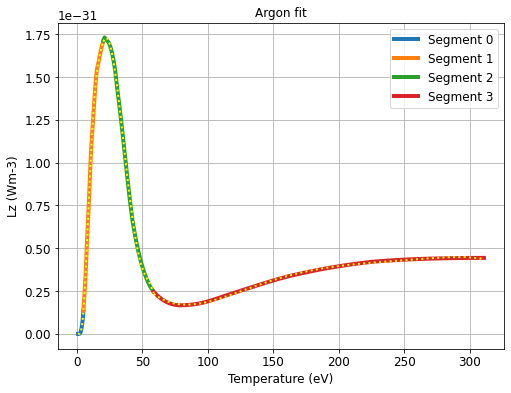

In [51]:
divs = [0, 5, 20, 60, Tarr_trim[-1]]
Tarr_slices = []
Lz_slices = []
coeffs = []
fitters = []
fits = []
fig, ax = plt.subplots(figsize=(8,6))


for j, div in enumerate(divs):
    if j > 0:
        Tarr_slice, Lz_slice = arrslice(Tarr_trim, Lz_trim["Ar"][1], divs[j-1], divs[j]) 
        Tarr_slices.append(Tarr_slice)
        Lz_slices.append(Lz_slice)

        coeffs.append(np.polyfit(Tarr_slice,Lz_slice, 5))
        fitters.append(np.poly1d(coeffs[j-1]))
        fits.append(fitters[j-1](Tarr_slice))

colors = [plt.get_cmap("tab10")(x) for x in range(len(fits))]
for k, fit in enumerate(fits):
    ax.plot(Tarr_slices[k], fits[k], linestyle = "dotted", color = "yellow", zorder = 3, linewidth = 2)
    ax.plot(Tarr_slices[k], Lz_slices[k], color = colors[k], linewidth = 4, label = "Segment {}".format(k))
    
ax.grid()
ax.legend()
ax.set_xlabel("Temperature (eV)")
ax.set_ylabel("Lz (Wm-3)")
ax.set_title("Argon fit")

Text(0.5, 1.0, 'Argon fit')

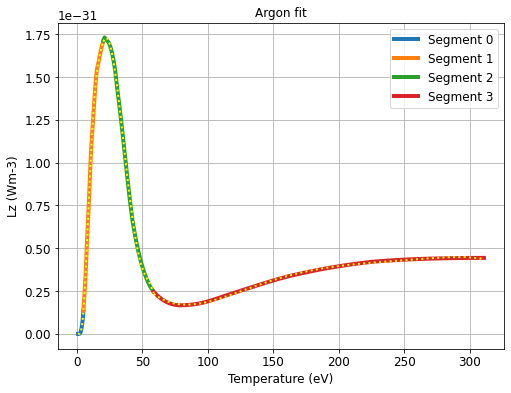

In [51]:
divs = [0, 5, 20, 60, Tarr_trim[-1]]
Tarr_slices = []
Lz_slices = []
coeffs = []
fitters = []
fits = []
fig, ax = plt.subplots(figsize=(8,6))


for j, div in enumerate(divs):
    if j > 0:
        Tarr_slice, Lz_slice = arrslice(Tarr_trim, Lz_trim["Ar"][1], divs[j-1], divs[j]) 
        Tarr_slices.append(Tarr_slice)
        Lz_slices.append(Lz_slice)

        coeffs.append(np.polyfit(Tarr_slice,Lz_slice, 5))
        fitters.append(np.poly1d(coeffs[j-1]))
        fits.append(fitters[j-1](Tarr_slice))

colors = [plt.get_cmap("tab10")(x) for x in range(len(fits))]
for k, fit in enumerate(fits):
    ax.plot(Tarr_slices[k], fits[k], linestyle = "dotted", color = "yellow", zorder = 3, linewidth = 2)
    ax.plot(Tarr_slices[k], Lz_slices[k], color = colors[k], linewidth = 4, label = "Segment {}".format(k))
    
ax.grid()
ax.legend()
ax.set_xlabel("Temperature (eV)")
ax.set_ylabel("Lz (Wm-3)")
ax.set_title("Argon fit")

Text(0, 0.5, 'Lz ($Wm^{-3}$)')

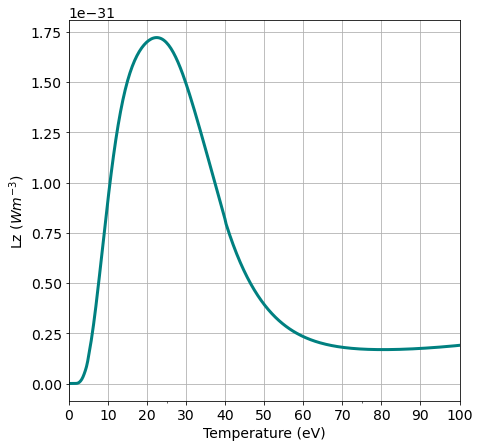

In [12]:
Te = np.linspace(0,300, 1000)
Lz = [LfuncKallenbachAr(x) for x in Te]

fig, ax = plt.subplots(figsize = (7,7))
ax.plot(Te,Lz, color = "teal")
ax.set_xlim(0,100)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.set_xlabel("Temperature (eV)")
ax.set_ylabel("Lz ($Wm^{-3}$)")

### Check near 1eV. It can be tricky here

(1e-36, 1e-33)

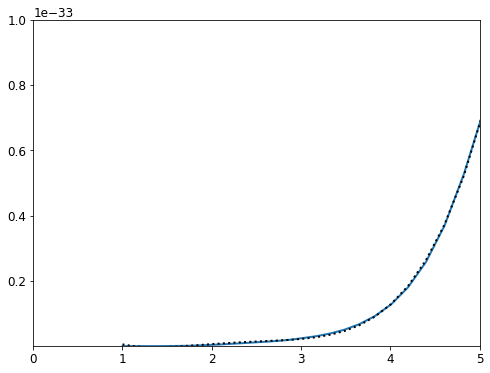

In [276]:
fig, ax = plt.subplots(figsize=(8,6))

colors = [plt.get_cmap("tab10")(x) for x in range(len(fits))]

for i, x in enumerate(fits):
    
    ax.plot(Tarr_slices[i], fits[i], linestyle = "dotted", color = "black", zorder = 3, linewidth = 2)
    ax.plot(Tarr_slices[i], Lz_slices[i], color = colors[i], linewidth = 2)
    
ax.set_xlim(0,5)
ax.set_ylim(1e-36, 1e-33)

## Manually print coefficients and assemble the functions in AnalyticCoolingCurves.py

In [268]:
coeffs[2]

array([ 2.25354957e-53, -3.69192130e-50,  2.54787258e-47, -9.47932318e-45,
        1.97532243e-42, -1.94373386e-40, -4.50456808e-39,  3.41720857e-36,
       -3.67272828e-34,  1.62817217e-32, -2.03213689e-31])

In [245]:
T = 1.0

if T >= 1 and T < 5:
    Lz = np.poly1d(
        [-7.31349415e-38,  1.93202142e-36, -2.22916113e-35,  1.47759381e-34,
       -6.22728157e-34,  1.74652508e-33, -3.31631764e-33,  4.24000336e-33,
       -3.51509184e-33,  1.71002985e-33, -3.69832235e-34])(T)
        
elif T > 5 and T < 40:
    Lz = np.poly1d(
        [ 2.29496770e-45, -8.10783697e-43,  1.11804695e-40, -8.26465601e-39,
        3.68332021e-37, -1.03900422e-35,  1.87877062e-34, -2.15159577e-33,
        1.50337186e-32, -5.65180585e-32,  8.64376408e-32])(T)
    
elif T > 40 and T < 300:
    Lz = np.poly1d(
        [ 2.25354957e-53, -3.69192130e-50,  2.54787258e-47, -9.47932318e-45,
        1.97532243e-42, -1.94373386e-40, -4.50456808e-39,  3.41720857e-36,
       -3.67272828e-34,  1.62817217e-32, -2.03213689e-31])(T)
    
elif T > 300:
    Lz = 0
elif T < 1:
    Lz = 0
    
Lz = abs(Lz)
Lz

5.728239199978747e-36

## Test fits

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


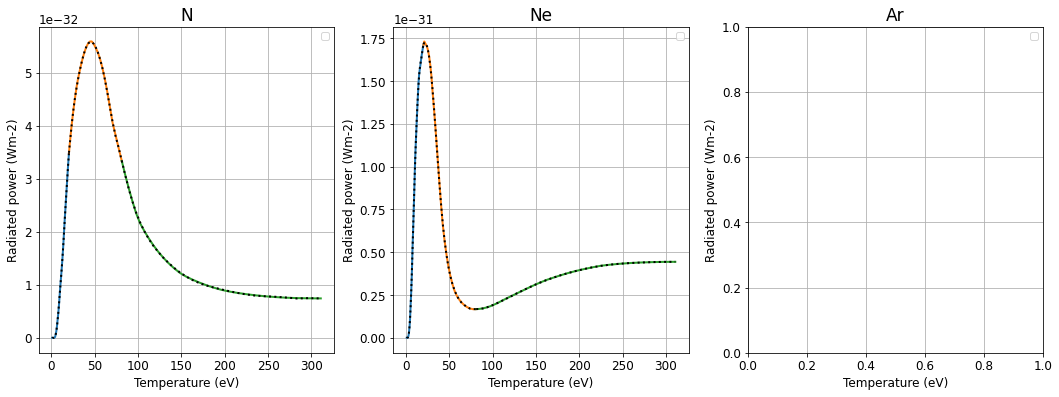

In [44]:
store_colors = dict(zip(imps,[plt.get_cmap("tab10")(x) for x in range(3)]))
colors = [plt.get_cmap("tab10")(x) for x in range(len(fits))]

fig, axes = plt.subplots(1,3,figsize=(18,6))

T_new = np.insert(Tarr, 0, [0,0.99])

tau = 1

for i, imp in enumerate(imps):
    
    divs = [0, 20, 80, Tarr_trim[-1]]
    Tarr_slices = []
    Lz_slices = []
    coeffs = []
    fitters = []
    fits = []

    for j, div in enumerate(divs):
        if j > 0:
            Tarr_slice, Lz_slice = arrslice(Tarr_trim, Lz_trim[imp][1], divs[j-1], divs[j]) 
            Tarr_slices.append(Tarr_slice)
            Lz_slices.append(Lz_slice)

            coeffs.append(np.polyfit(Tarr_slice,Lz_slice, 10))
            fitters.append(np.poly1d(coeffs[j-1]))
            fits.append(fitters[j-1](Tarr_slice))
    
    for k, fit in enumerate(fits):
        ax.plot(Tarr_slices[k], fits[k], linestyle = "dotted", color = "black", zorder = 3, linewidth = 2)
        ax.plot(Tarr_slices[k], Lz_slices[k], color = colors[k], linewidth = 2)
    
    coeffs = np.polyfit(Tarr_trim,Lz_trim[imp][1], 8)   
    yfit = np.zeros_like(Tarr)
    yfitter = np.poly1d(coeffs)
    yfit = yfitter(Tarr_trim)
    
    ax = axes[i]
    # ax.plot(Tarr_trim, Lz_trim[imp][1], color = store_colors[imp], linewidth = 2, linestyle = "solid", label = r"Base")
    # ax.plot(Tarr_trim, yfit, color = "black", linewidth = 2, linestyle = (0, (5, 3)), label = r"Interpolation")


    # ax.set_xlim(0,300)
    # ax.set_ylim(0,1e-35)
    ax.grid()
    ax.set_xlabel("Temperature (eV)")
    ax.set_ylabel("Radiated power (Wm-2)")
    ax.legend(fontsize = 10)
    ax.set_title(f"{imp}", fontsize = 17)

## Test functions

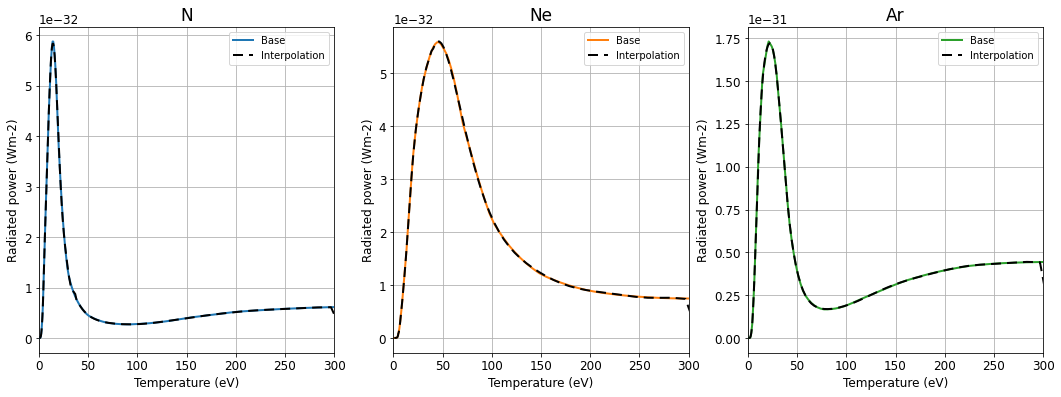

In [271]:
store_colors = dict(zip(imps,[plt.get_cmap("tab10")(x) for x in range(3)]))

fig, axes = plt.subplots(1,3,figsize=(18,6))

T_new = np.insert(Tarr, 0, [0,0.99])

tau = 1

for i, imp in enumerate(imps):
    ax = axes[i]
    ax.plot(Tarr, Lz[imp][1], color = store_colors[imp], linewidth = 2, linestyle = "solid", label = r"Base")
    
    if imp == "N":
        ax.plot(Tarr, [LfuncKallenbachN(x) for x in Tarr], color = "black", linewidth = 2, linestyle = (0, (5, 3)), label = r"Interpolation")
    if imp == "Ar":
        ax.plot(Tarr, [LfuncKallenbachAr(x) for x in Tarr], color = "black", linewidth = 2, linestyle = (0, (5, 3)), label = r"Interpolation")
    if imp == "Ne":
        ax.plot(Tarr, [LfuncKallenbachNe(x) for x in Tarr], color = "black", linewidth = 2, linestyle = (0, (5, 3)), label = r"Interpolation")

    ax.set_xlim(0,300)
    # ax.set_ylim(0,1e-35)
    ax.grid()
    ax.set_xlabel("Temperature (eV)")
    ax.set_ylabel("Radiated power (Wm-2)")
    ax.legend(fontsize = 10)
    ax.set_title(f"{imp}", fontsize = 17)

# Compare performance of Kallenbach vs. original fits

In [194]:
imp_study_KAr = dict()
study = imp_study_KAr

labels = ["Kallenbach", "Kallenbach 200eV", "Kallenbach 150eV", "Kallenbach 100eV", "Kallenbach 100eV B", "Original"]

for side in data.keys():

    print("Solving side", side)
    out = []
    results = dict()
    study[side] = dict()
        
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []

    for i, Lfunc in enumerate([LfuncKallenbachAr, LfuncKallenbachAr200, LfuncKallenbachAr150, LfuncKallenbachAr100, LfuncKallenbachAr100B, LfuncAr]):
        label = labels[i]
        print("Running function: {} -- ".format(labels[i]), end="")
        d = copy.deepcopy(data[side])
        constants = constants_default.copy()
        radios = radios_default.copy()
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        constants["Lfunc"] = Lfunc
        constants["nu0"] = 1e20

        out = LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 0.8, acceleration = 0, verbosity = 0,
                                            control_variable = "impurity_frac")
        
        out["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
        results["window"].append(out["cvar"][-1] - out["cvar"][0])
        results["window_ratio"].append(out["cvar"][-1] / out["cvar"][0])
        results["threshold"].append(out["cvar"][0])
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios
        results["out"] = out
        
        study[side][label] = results.copy()
    

Solving side iu
Running function: Kallenbach -- Solving...0...14...24...32...38...43...46...48...49...51...Complete in 29.9 seconds
Running function: Kallenbach 200eV -- Solving...0...14...24...32...38...43...46...48...49...51...Complete in 27.4 seconds
Running function: Kallenbach 150eV -- Solving...0...14...24...32...38...43...46...48...49...51...Complete in 29.8 seconds
Running function: Kallenbach 100eV -- Solving...0...14...24...32...38...43...46...48...49...51...Complete in 32.1 seconds
Running function: Kallenbach 100eV B -- Solving...0...14...24...32...38...43...46...48...49...51...Complete in 32.4 seconds
Running function: Original -- Solving...0...14...24...32...38...43...46...48...49...51...Complete in 20.7 seconds
Solving side ou
Running function: Kallenbach -- Solving...0...39...67...91...115...136...151...160...166...169...Complete in 28.7 seconds
Running function: Kallenbach 200eV -- Solving...0...39...67...91...115...136...151...160...166...169...Complete in 29.3 second

Text(0.5, 1.0, 'Inner divertor')

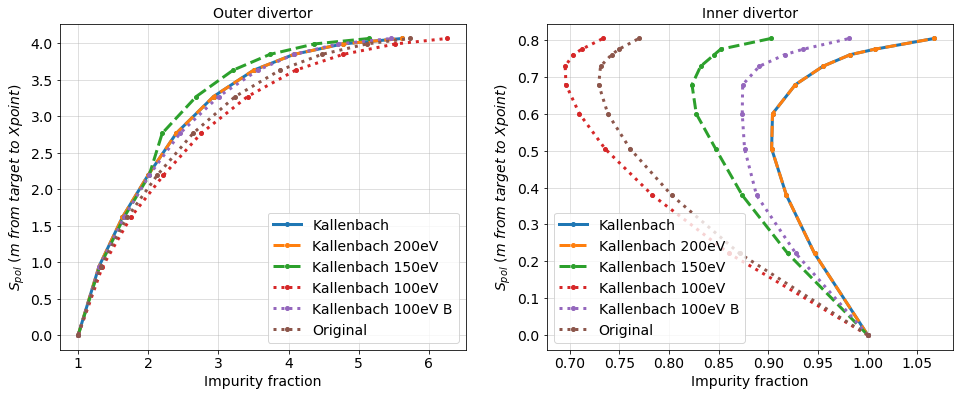

In [202]:
fig, axes = plt.subplots(1,2, figsize = (16,6))
styles = ["solid", "dashed", "dashed", "dotted", "dotted", "dotted", "dashed"]
ax = axes[0]
side = "ou"

for i, label in enumerate(labels):
    o = imp_study_KAr[side][label]["out"]
    
    ax.plot(o["crel"], o["SpolPlot"], 
            label = "{}".format(label), linewidth = 3, marker = "o", markersize = 4, linestyle = styles[i])
    
ax.set_xlabel("Impurity fraction")
ax.set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
ax.grid(alpha = 0.5)
ax.legend()
ax.set_title("Outer divertor")
# ax.xaxis.set_minor_locator(MultipleLocator(0.005))
# ax.xaxis.set_major_locator(MultipleLocator(0.01))

ax = axes[1]
side = "iu"


for i, label in enumerate(labels):
    o = imp_study_KAr[side][label]["out"]
    
    ax.plot(o["crel"], o["SpolPlot"], 
            label = "{}".format(label), linewidth = 3, marker = "o", markersize = 4, alpha = 1, linestyle = styles[i])
    
ax.set_xlabel("Impurity fraction")
ax.set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
ax.grid(alpha = 0.5)
ax.legend()
ax.set_title("Inner divertor")

# results = imp_study["ou"]
# for i, imp in enumerate(imp_labels):
#     ax.plot(results["out"][i]["cvar"], results["out"][i]["Splot"], label = "{}".format(imp), linewidth = 3, marker = "o", markersize = 4)
# ax.set_xlabel("Impurity fraction")
# ax.set_ylabel("$S_{par}\ (m\ from\ target\ to\ Xpoint)$")
# ax.grid(alpha = 0.5)
# ax.legend()
# ax.set_title("Outer divertor")
# ax.xaxis.set_minor_locator(MultipleLocator(0.01))
# ax.xaxis.set_major_locator(MultipleLocator(0.05))
# ax.set_xlim(0.001,0.017)

# norm = mpl.colors.BoundaryNorm(results["list_BxBt"], cmap.N, extend= "both")
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),  orientation="vertical", label = "Flux expansion ($B_{x}\//B_{t}$)")
# cb.ax.set_yticklabels(["{:.2f}".format(i) for i in cb.get_ticks()]) 
# "yep"

In [201]:
styles

['solid', 'dashed', 'dashed', 'dotted', 'dotted']

# Plot radiation zones in RZ space

Text(0, 0.5, 'Z (m)')

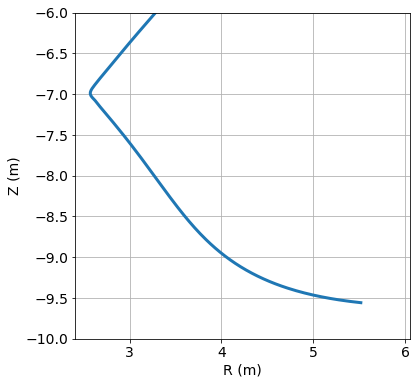

In [61]:
fig, ax = plt.subplots(figsize = (6,6))

o = imp_study_KAr["ou"]["Kallenbach"]["out"]

x = d["R"]
y = d["Z"]

dydx = np.array(widths[k])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(global_min, global_max)
lc = LineCollection(segments, cmap='gist_ncar', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(5)
line = ax.add_collection(lc)

ax.set_ylim(-10,-6)
ax.plot(d["R"], -d["Z"])
ax.set_xlabel("R (m)"); ax.set_ylabel("Z (m)")

In [90]:
mins = []
maxes = []
for profile in o["Rprofiles"]:
    mins.append(min(profile))
    maxes.append(max(profile))
global_min = min(mins)
global_max = max(maxes)


In [99]:
global_max

1274158351.2985952

C:\Users\Mike\AppData\Local\Temp/ipykernel_13048/2255715974.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


Text(0.5, 1.0, 'Temperature profiles for scan of front locations')

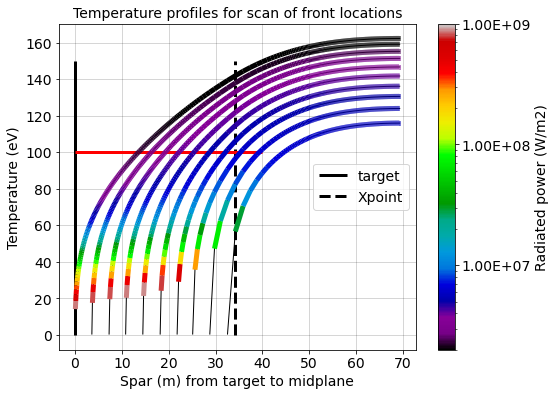

In [140]:
side = "ou"

fig, ax = plt.subplots(figsize=(8,6))
o = imp_study_KAr["ou"]["Kallenbach"]["out"]



cmap = plt.get_cmap("plasma")
colors = make_colors(len(o["Tprofiles"]), cmap)   


for i, Tprofile in enumerate(o["Tprofiles"]):
    ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)
    
    x = o["Sprofiles"][i]
    y = Tprofile
    z = np.array(o["Rprofiles"][i])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(2e6, 1e9)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
    lc.set_array(z)
    lc.set_linewidth(5)
    lc.set_zorder(10)
    line = ax.add_collection(lc)
    
ax.vlines(0, 0, 150, zorder = 5, label = "target", color = "black", linewidth = 3)
ax.vlines(data[side]["S"][data[side]["Xpoint"]], 0, 150, zorder = 5, label = "Xpoint", color = "black", linewidth = 3, linestyle = "dashed")
ax.hlines(100,0,40,color ="red", zorder = 5)

# norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (W/m2)")
cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()]) 

ax.legend(loc="center right")
ax.grid(color = "black", alpha = 0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")
ax.set_title("Temperature profiles for scan of front locations")

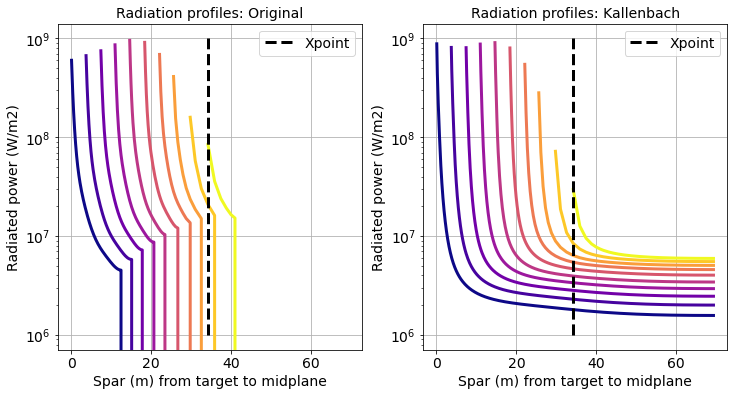

In [164]:
fig, axes = plt.subplots(1,2, figsize=(12,6))


colors = make_colors(len(o["Tprofiles"]), plt.get_cmap("plasma"))  

ax = axes[0]
ax.set_title("Radiation profiles: Original")
o = imp_study_KAr["ou"]["Original"]["out"]


for i, _ in enumerate(o["Sprofiles"]):
    Rprofile = o["Rprofiles"][i]
    Rprofile[Rprofile==0] = np.nan
    ax.plot(o["Sprofiles"][i], Rprofile, color = colors[i])
    
ax = axes[1]
ax.set_title("Radiation profiles: Kallenbach")
o = imp_study_KAr["ou"]["Kallenbach"]["out"]
for i, _ in enumerate(o["Sprofiles"]):
    Rprofile = o["Rprofiles"][i]
    Rprofile[Rprofile==0] = np.nan
    ax.plot(o["Sprofiles"][i], o["Rprofiles"][i], color = colors[i])

for ax in axes:
    ax.vlines(data[side]["S"][data[side]["Xpoint"]], 1e6, 1e9, zorder = 5, label = "Xpoint", color = "black", linewidth = 3, linestyle = "dashed")    
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel("Spar (m) from target to midplane")
    ax.set_ylabel("Radiated power (W/m2)")

# plt.xlim(0,3)